In [2]:
import warnings
warnings.filterwarnings("ignore")

# 3. Transformers in `sktime`

Until now: How can we use sktime to create forecasts.


Now: How can we improve the forecasts.



## 3.1 Wherefore transformers?

Tranformers in `sktime` referr to a catch-all term that encompses modular data processing steps.

We use this term in the `sklearn` sense, so this is unrelated to transformers in NLP or deep learning.

suppose we want to forecast this well-known dataset
(airline passengers by year in a fixed scope)

In [1]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

y = load_airline()
plot_series(y)

ModuleNotFoundError: No module named 'matplotlib'. 'matplotlib' is a soft dependency and not included in the base sktime installation. Please run: `pip install matplotlib` to install the matplotlib package. To install all soft dependencies, run: `pip install sktime[all_extras]`

observations:

* there is seasonal periodicity, 12 month period
* seasonal periodicity looks multiplicative (not additive) to trend

idea: forecast might be easier

* with seasonality removed
* on logarithmic value scale (multiplication becomes addition)

### 3.1.1 Manual tranformations: doing things the wrong way

Maybe doing this manually step by step is a good idea?

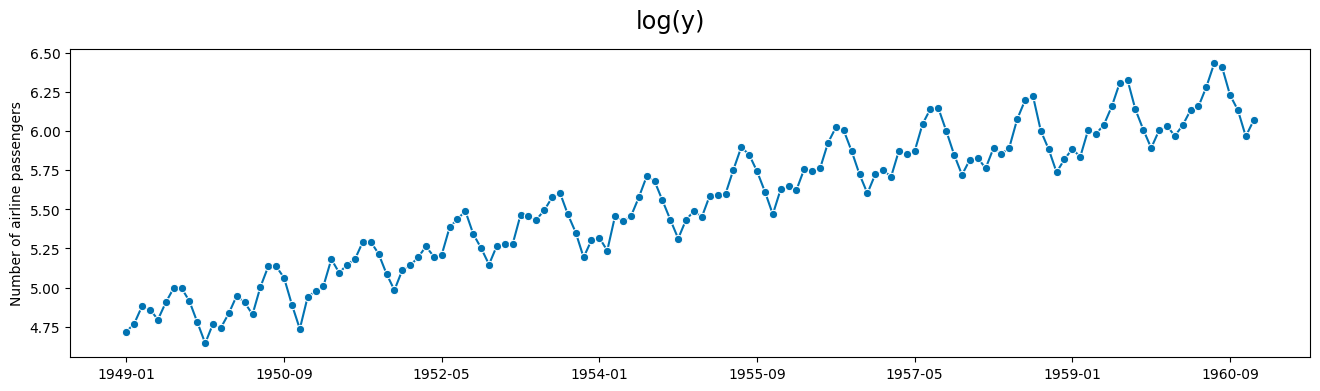

In [63]:
import numpy as np

y_log = np.log(y)

fig, ax = plot_series(y_log, title="log(y)")

this looks additive now!

ok, what next - deaseasonalization

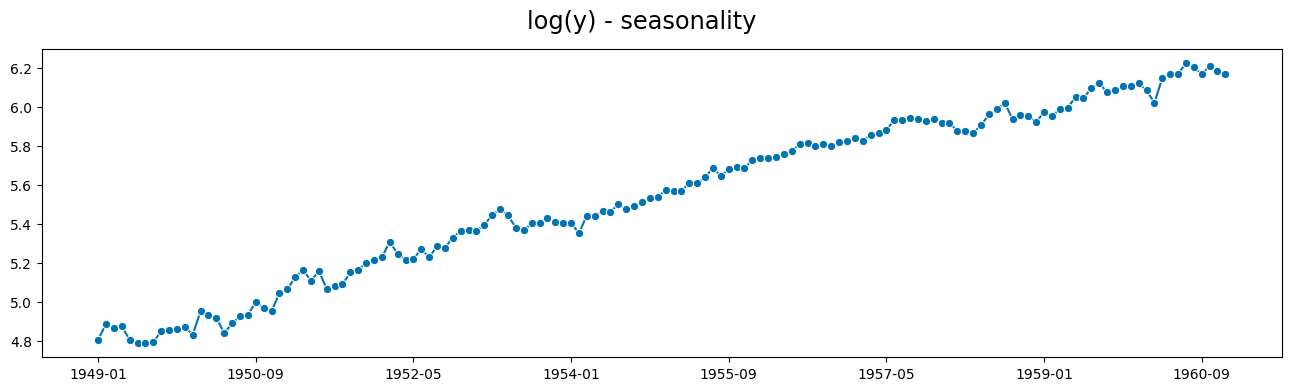

In [64]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_result = seasonal_decompose(y_log, period=12)
seasonal = seasonal_result.seasonal
y_log_deseasonalised = y_log - seasonal

fig, ax = plot_series(y_log_deseasonalised, title="log(y) - seasonality")

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='trend'>)

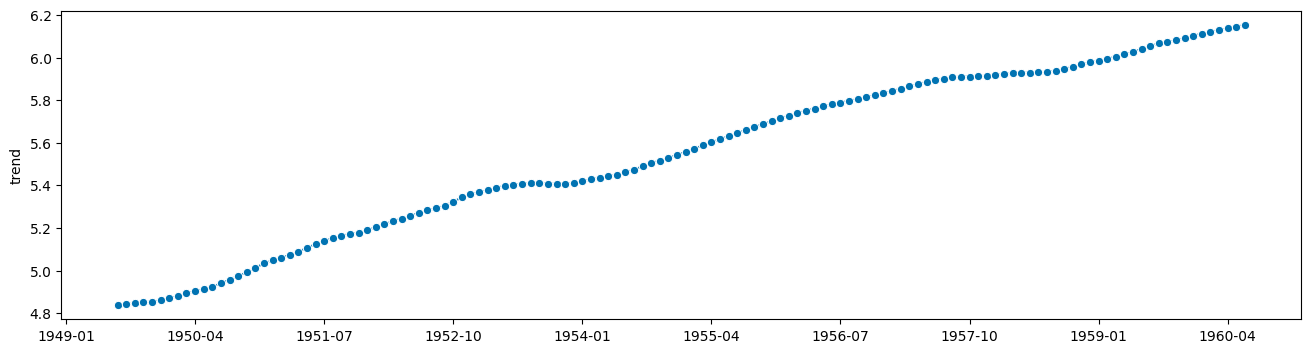

In [65]:
trend = seasonal_result.trend
plot_series(trend)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='seasonal'>)

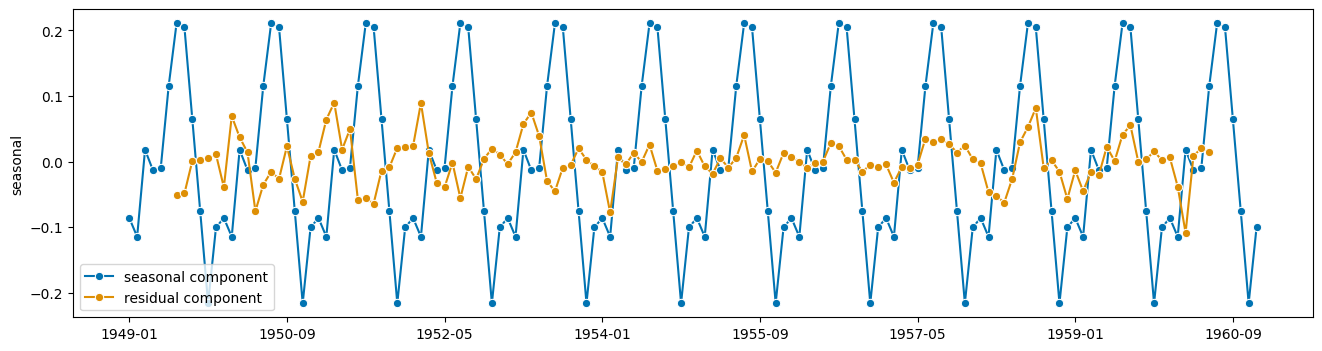

In [66]:
resid = seasonal_result.resid
plot_series(seasonal, resid, labels=["seasonal component", "residual component"])

now:

* forecast on this
* add back seasonal component
* invert logarithm (exponentiate)

start with forecast...

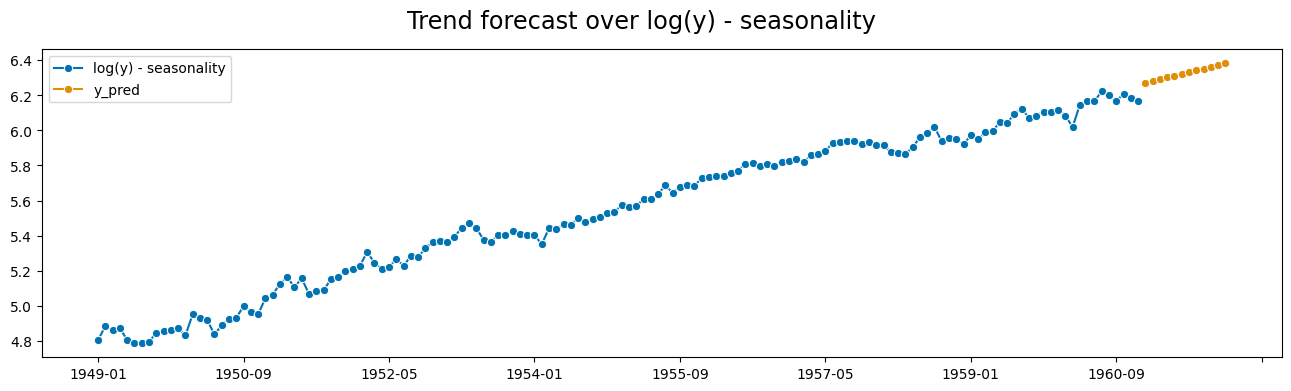

In [67]:
from sktime.forecasting.trend import TrendForecaster

forecaster = TrendForecaster()

fh = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] # Alternatively: list(range(1, 13))
y_pred = forecaster.fit_predict(y_log_deseasonalised, fh=fh)

fig, ax = plot_series(
    y_log_deseasonalised,
    y_pred,
    labels=["log(y) - seasonality", "y_pred"],
    title="Trend forecast over log(y) - seasonality",
)

looks reasonable!

Now to turn this into a forecast of the original y ...

* add seasonal
* invert the logarithm

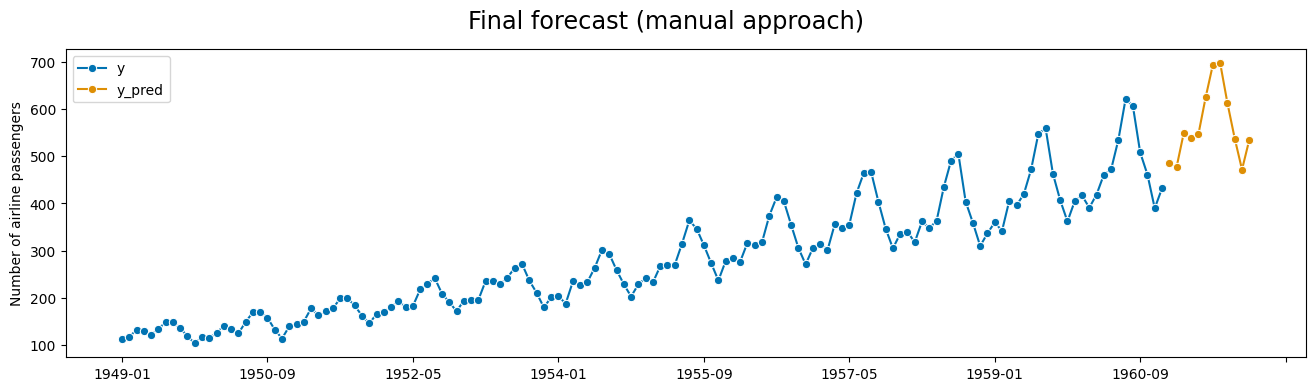

In [68]:
y_pred_add_seasonality = y_pred + seasonal[0:12].values
y_pred_orig = np.exp(y_pred_add_seasonality)

fig, ax = plot_series(y, y_pred_orig, labels=["y", "y_pred"], title="Final forecast (manual approach)")

ok, done! and it only took us 10 years.

Maybe there is a better way?

### 1.1.2 `sktime` transformers: doing things the right way


Solution: use transformers & pipelines!

Same interface at every step! Easily composable!


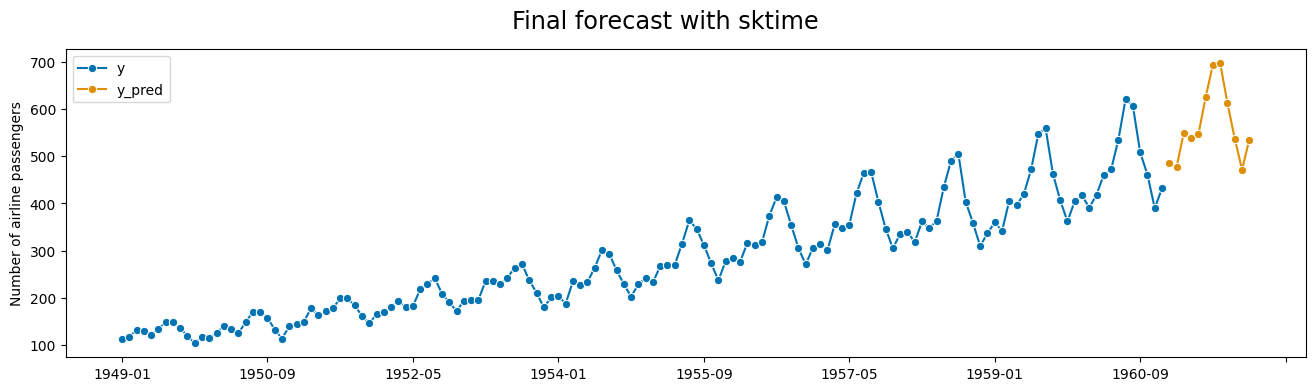

In [69]:
from sktime.forecasting.trend import TrendForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer

y = load_airline()

forecaster = LogTransformer() * Deseasonalizer(sp=12) * TrendForecaster()

fh = list(range(1, 13))
y_pred = forecaster.fit_predict(y, fh=fh)

fig, ax = plot_series(y, y_pred, labels=["y", "y_pred"], title="Final forecast with sktime")

what happened here?

The "chain" operator `*` creates a "forecasting pipeline"

Has the same interface as all other forecasters! No additional data fiddling!

Transformers "slot in" as standardized components.

In [70]:
forecaster

TransformedTargetForecaster(steps=[LogTransformer(), Deseasonalizer(sp=12),
                                   TrendForecaster()])

Let's look at this in more detail:

* `sktime` transformers interface
* `sktime` pipeline building

## 1.2 Transformers - More Detailed

* transformer interface
* transformer types
* searching transformers by type
* broadcasting/vectorization to panel & hierarchical data
* transformers and pipelines

### 1.2.1 What are transformers? <a class="anchor" id="section_1_1"></a>

Transformer = modular data processing steps commonly used in machine learning

("transformer" used in the sense of `scikit-learn`)

Transformers are estimators that:

* are fitted to a batch of data via `fit(data)`, changing its state
* are applied to another batch of data via `transform(X)`, producing transformed data
* may have an `inverse_transform(X)`

In `sktime`, input `X` to `fit` and `transform` is typically a time series or a panel (collection of time series).

Basic use of an `sktime` time series transformer is as follows:

In [71]:
# 1. prepare the data
from sktime.utils._testing.series import _make_series

X = _make_series()
X_train = X[:7]
X_test = X[7:12]
# X_train and X_test are both pandas.Series

X_train, X_test

(2000-01-01    4.081618
 2000-01-02    4.283742
 2000-01-03    3.622857
 2000-01-04    3.200899
 2000-01-05    3.471681
 2000-01-06    5.580949
 2000-01-07    3.784293
 Freq: D, dtype: float64,
 2000-01-08    3.647767
 2000-01-09    3.264423
 2000-01-10    4.174777
 2000-01-11    4.299363
 2000-01-12    1.200172
 Freq: D, dtype: float64)

In [72]:
# 2. construct the transformer
from sktime.transformations.series.boxcox import BoxCoxTransformer

# trafo is an sktime estimator inheriting from BaseTransformer
# Box-Cox transform with lambda parameter fitted via mle
trafo = BoxCoxTransformer(method="mle")

In [73]:
# 3. fit the transformer to training data
trafo.fit(X_train)

# 4. apply the transformer to transform test data
# Box-Cox transform with lambda fitted on X_train
X_transformed = trafo.transform(X_test)

X_transformed

2000-01-08    0.371588
2000-01-09    0.367126
2000-01-10    0.375534
2000-01-11    0.376226
2000-01-12    0.145314
Freq: D, dtype: float64

If the training and test set is the same, step 3 and 4 can be carried out more concisely (and sometimes more efficiently) by using `fit_transform`:

In [74]:
# 3+4. apply the transformer to fit and transform on the same data, X
X_transformed = trafo.fit_transform(X)

### 1.2.2 Different types of transformers <a class="anchor" id="section_1_2"></a>

`sktime` distinguishes different types of transformer, depending on the input type of `fit` and `transform`, and the output type of `transform`.

Common types of transformation in `sktime`:

| from | to | base class | examples (sci) | examples (`sktime`) |
| --- | --- | --- | --- | --- |
| time series | scalar features | `BaseTransformer` (`Primitives` output) | `tsfresh`, or 7-number-summary | `Catch22`,`SummaryTransformer` |
| time series | time series | `BaseTransformer` (`Series`, `instancewise`)  | detrending, smoothing, filtering, lagging | `Detrender`,`Differencer`, `Lag`, `Filter` |
| time series panel | also a panel | `BaseTransformer` (`Series` output)  | principal component projection | `PCATransformer`,`PaddingTransformer` |
| two feature vectors | a scalar | `BasePairwiseTransformer` | Euclidean distance, L1 distance | `ScipyDist`, `AggrDist`, `FlatDist` |
| two time series | a scalar | `BasePairwiseTransformerPanel` | DTW distance, alignment kernel | `DtwDist`, `EditDist` |

To illustrate the difference, we compare two transformers with different output:

* the Box-Cox transformer `BoxCoxTrannsformer`, which transforms a time series to a time series
* the summary transformer `SummaryTransformer`, which transforms a time series to scalars such as the mean


In [75]:
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.transformations.series.summarize import SummaryTransformer

y = load_airline()

boxcox = BoxCoxTransformer()
summary = SummaryTransformer()

In [76]:
# BoxCoxTransformer() produces a pd.Series
boxcox.fit_transform(y)

Period
1949-01     6.827490
1949-02     6.932822
1949-03     7.161892
1949-04     7.114611
1949-05     6.983787
             ...    
1960-08    10.684049
1960-09    10.234573
1960-10     9.992159
1960-11     9.582623
1960-12     9.831860
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

In [77]:
# SummaryTransformer() produces a (set of) scalar (values)
summary.fit_transform(y)

,mean,std,min,max,0.1,0.25,0.5,0.75,0.9
0,280.298611,119.966317,104.0,622.0,135.3,180.0,265.5,360.5,453.2


 For time series transformers, the metadata tags describe the expected output of `transform`:

In [78]:
boxcox.get_tag("scitype:transform-output")

'Series'

In [79]:
summary.get_tag("scitype:transform-output")

'Primitives'

To find transformers, use `all_estimators` and filter by tags:

* `"scitype:transform-output"` - the output scitype. `Series` for time series, `Primitives` for primitive features (float, categories), `Panel` for collections of time series.
* `"scitype:transform-input"` - the input scitype. `Series` for time series.
* `"scitype:instancewise"` - If `True`, vectorized operation per series. If `False`, uses multiple time series non-trivially.

Example: find all transformers that output time series

In [80]:
from sktime.registry import all_estimators

# now subset to transformers that extract scalar features
all_estimators(
    "transformer",
    as_dataframe=True,
    filter_tags={"scitype:transform-output": "Series"},
    suppress_import_stdout=False,
)

,name,object
0,Aggregator,<class 'sktime.transformations.hierarchical.ag...
1,AutoCorrelationTransformer,<class 'sktime.transformations.series.acf.Auto...
2,BKFilter,<class 'sktime.transformations.series.bkfilter...
3,BoxCoxTransformer,<class 'sktime.transformations.series.boxcox.B...
4,CFFilter,<class 'sktime.transformations.series.cffilter...
...,...,...
85,TruncationTransformer,<class 'sktime.transformations.panel.truncatio...
86,VmdTransformer,<class 'sktime.transformations.series.vmd._vmd...
87,WhiteNoiseAugmenter,<class 'sktime.transformations.series.augmente...
88,WindowSummarizer,<class 'sktime.transformations.series.summariz...


A more complete overview on transformer types and tags is given in the `sktime` transformers tutorial.


### 1.2.3 Hierachical Transformers

* Either transformers are natively multivariate or
* If not: Broadcasting aka vectorization of transformers

This ensures that all `sktime` transformers can be applied to multivariate and multi-instance (panel, hierarchical) time series data.

Example 1: broadcasting/vectorization of time series to time series transformer

The `BoxCoxTransformer` from previous sections applies to single instances of univariate time series. When multiple instances or variables are seen, it broadcasts across both:

In [81]:
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.utils._testing.hierarchical import _make_hierarchical

# hierarchical data with 2 variables and 2 levels
X = _make_hierarchical(n_columns=2)

X

c0        c1
h0   h1   time                          
h0_0 h1_0 2000-01-01  3.627233  4.471915
          2000-01-02  2.636006  2.857282
          2000-01-03  5.851413  3.460801
          2000-01-04  4.534789  2.701331
          2000-01-05  4.409497  2.545265
...                        ...       ...
h0_1 h1_3 2000-01-08  5.173427  4.075307
          2000-01-09  6.148393  3.262279
          2000-01-10  2.126504  4.655735
          2000-01-11  4.603506  3.608856
          2000-01-12  5.075842  4.463476

[96 rows x 2 columns]

In [82]:
# constructing the transformers
boxcox_trafo = BoxCoxTransformer(method="mle")

# applying to X results in hierarchical data
boxcox_trafo.fit_transform(X)

c0        c1
h0   h1   time                           
h0_0 h1_0 2000-01-01   2.952540  1.998340
          2000-01-02   1.779370  1.281603
          2000-01-03   5.749755  1.573820
          2000-01-04   4.069939  1.199846
          2000-01-05   3.913532  1.114986
...                         ...       ...
h0_1 h1_3 2000-01-08  20.710059  0.987596
          2000-01-09  31.475746  0.876177
          2000-01-10   2.115841  1.048192
          2000-01-11  15.575928  0.928378
          2000-01-12  19.771880  1.029466

[96 rows x 2 columns]

Fitted model components of vectorized transformers can be found in the `transformers_` attribute, or accessed via the universal `get_fitted_params` interface:

In [83]:
boxcox_trafo.transformers_
# this is a pandas.DataFrame that contains the fitted transformers
# one per time series instance and variable

c0                   c1
h0_0 h1_0  BoxCoxTransformer()  BoxCoxTransformer()
     h1_1  BoxCoxTransformer()  BoxCoxTransformer()
     h1_2  BoxCoxTransformer()  BoxCoxTransformer()
     h1_3  BoxCoxTransformer()  BoxCoxTransformer()
h0_1 h1_0  BoxCoxTransformer()  BoxCoxTransformer()
     h1_1  BoxCoxTransformer()  BoxCoxTransformer()
     h1_2  BoxCoxTransformer()  BoxCoxTransformer()
     h1_3  BoxCoxTransformer()  BoxCoxTransformer()

In [84]:
boxcox_trafo.get_fitted_params()
# this returns a dictionary
# the transformers DataFrame is available at the key "transformers"
# individual transformers are available at dataframe-like keys
# it also contains all fitted lambdas as keyed parameters

{'transformers':                             c0                   c1
 h0_0 h1_0  BoxCoxTransformer()  BoxCoxTransformer()
      h1_1  BoxCoxTransformer()  BoxCoxTransformer()
      h1_2  BoxCoxTransformer()  BoxCoxTransformer()
      h1_3  BoxCoxTransformer()  BoxCoxTransformer()
 h0_1 h1_0  BoxCoxTransformer()  BoxCoxTransformer()
      h1_1  BoxCoxTransformer()  BoxCoxTransformer()
      h1_2  BoxCoxTransformer()  BoxCoxTransformer()
      h1_3  BoxCoxTransformer()  BoxCoxTransformer(),
 "transformers.loc[('h0_0', 'h1_0'),'c0']": BoxCoxTransformer(),
 "transformers.loc[('h0_0', 'h1_0'),'c0']__lambda": 1.1480895812364378,
 "transformers.loc[('h0_0', 'h1_0'),'c1']": BoxCoxTransformer(),
 "transformers.loc[('h0_0', 'h1_0'),'c1']__lambda": 0.36810103547343764,
 "transformers.loc[('h0_0', 'h1_1'),'c0']": BoxCoxTransformer(),
 "transformers.loc[('h0_0', 'h1_1'),'c0']__lambda": 0.6365708837357934,
 "transformers.loc[('h0_0', 'h1_1'),'c1']": BoxCoxTransformer(),
 "transformers.loc[('h0_0', '

Example 2: broadcasting/vectorization of time series to scalar features transformer

The `SummaryTransformer` behaves similarly.
Multiple time series instances are transformed to different columns of the resulting data frame.

In [85]:
from sktime.transformations.series.summarize import SummaryTransformer

summary_trafo = SummaryTransformer()

# this produces a pandas DataFrame with more rows and columns
# rows correspond to different instances in X
# columns are multiplied and names prefixed by [variablename]__
# there is one column per variable and transformed feature
summary_trafo.fit_transform(X)

c0__mean   c0__std   c0__min   c0__max   c0__0.1  c0__0.25  \
h0   h1                                                                 
h0_0 h1_0  4.694515  1.085345  2.636006  6.575725  3.636553  4.071760   
     h1_1  4.373584  0.782632  3.195653  5.619599  3.432821  3.699440   
     h1_2  4.744549  1.245665  1.000000  5.828899  4.423326  4.737025   
     h1_3  4.439091  0.787900  2.913009  5.549346  3.433578  4.094876   
h0_1 h1_0  4.885948  0.907065  3.799885  7.306140  4.167306  4.384745   
     h1_1  4.253406  1.215891  1.957107  6.260949  2.846806  3.723015   
     h1_2  4.291416  0.946088  2.420171  6.078069  3.369856  3.779058   
     h1_3  4.606858  1.052899  2.126504  6.148393  3.512946  4.322229   

            c0__0.5  c0__0.75   c0__0.9  c1__mean   c1__std   c1__min  \
h0   h1                                                                 
h0_0 h1_0  4.660849  5.328480  5.831492  3.633469  0.805163  2.545265   
     h1_1  4.496294  4.681020  5.491467  3.606483  0.581088  2.341956   
     h1_2  4.995522  5.313886  5.531895  3.620174  0.572913  2.633113   
     h1_3  4.489000  4.922119  5.362555  3.641617  1.157202  1.499797   
h0_1 h1_0  4.687171  5.071493  5.557285  3.431685  0.898553  1.000000   
     h1_1  4.228246  4.768361  5.878720  3.721659  1.143159  1.379384   
     h1_2  4.317876  4.700733  5.241902  3.282725  0.717115  2.008851   
     h1_3  4.907048  5.100238  5.489216  4.167514  0.883705  3.027143   

            c1__max   c1__0.1  c1__0.25   c1__0.5  c1__0.75   c1__0.9  
h0   h1                                                                
h0_0 h1_0  4.799412  2.709635  2.839054  3.564150  4.349378  4.661902  
     h1_1  4.783617  3.141417  3.329408  3.697935  3.850396  3.889688  
     h1_2  4.526448  3.063861  3.285056  3.471601  4.058904  4.352733  
     h1_3  5.601163  2.227030  3.074661  3.869221  4.144049  5.011836  
h0_1 h1_0  4.478575  2.945857  3.265305  3.460298  3.976304  4.225311  
     h1_1  5.310448  2.580942  2.893937  3.952652  4.650948  4.743251  
     h1_2  4.125519  2.297190  2.948167  3.365134  3.869518  4.083874  
     h1_3  5.802844  3.207845  3.522212  3.995703  4.714337  5.321949

### 1.3 Sequential Pipelines, Combining Forecasters, and Feature Engineering

`sktime` transformers can be pipelined with any other `sktime` estimator type, including forecasters, classifiers, and other transformers.

Pipelines = estimators of the same type, same interface as specialized class

pipeline build operation: `make_pipeline` or via `*` dunder

Pipelining `pipe = trafo * est` produces `pipe` of same type as `est`.

In `pipe.fit`, first `trafo.fit_transform`, then `est.fit` is executed on the result.

In `pipe.predict`, first `trafo.transform`, then `est.predict` is executed.

(the arguments that are piped differ by type and can be looked up in the docstrings of pipeline classes, or specialized tutorials)


transformers are natural pipeline components

* data processing steps
* feature engineering steps
* post processing steps

they can be combined in a number of other ways:

* pipelining = sequential chaining
* feature union = parallel, addition of features
* feature subsetting = selecting columns
* inversion = switch transform and inverse
* multiplexing = switching between transformers
* passthrough = switch on/ off

### 1.3.1 Chaining transformers via `*`

In [86]:
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.summarize import SummaryTransformer

pipe = Differencer() * SummaryTransformer()

# this constructs a TransformerPipeline, which is also a transformer
pipe

TransformerPipeline(steps=[Differencer(), SummaryTransformer()])

In [87]:
from sktime.utils._testing.hierarchical import _bottom_hier_datagen

X = _bottom_hier_datagen(no_levels=1, no_bottom_nodes=2)

# this is a transformer with the same interface
# first applies differencer, then summary transform
pipe.fit_transform(X)

,mean,std,min,max,0.1,0.25,0.5,0.75,0.9
0,2.222222,33.636569,-101.00,87.00,-37.700,-16.00,3.50,22.25,43.00
1,28.622222,433.239014,-1300.88,1120.56,-485.576,-206.08,45.08,286.58,553.84


compatible with sklearn transformers!

default applies sklearn transformer per individual time series as a data frame table

In [88]:
from sklearn.preprocessing import StandardScaler

pipe = Differencer() * StandardScaler()

pipe

TransformerPipeline(steps=[Differencer(),
                           TabularToSeriesAdaptor(transformer=StandardScaler())])

In [89]:
pipe.fit_transform(X)

passengers
l1_agg    timepoints            
l1_node01 1949-01      -0.066296
          1949-02       0.112704
          1949-03       0.351370
          1949-04      -0.155796
          1949-05      -0.304963
...                          ...
l1_node02 1960-08      -0.543629
          1960-09      -2.989961
          1960-10      -1.468462
          1960-11      -2.184462
          1960-12       1.186703

[288 rows x 1 columns]

pipeline-adaptor chains can be constructed manually:

* `sktime.transformations.compose.TransformerPipeline`
* `sktime.transformations.series.adapt.TabularToSeriesAdaptor` for `sklearn`

composites are compatible with `get_params` / `set_params` parameter interface:

In [90]:
pipe.get_params()

{'steps': [Differencer(),
  TabularToSeriesAdaptor(transformer=StandardScaler())],
 'Differencer': Differencer(),
 'TabularToSeriesAdaptor': TabularToSeriesAdaptor(transformer=StandardScaler()),
 'Differencer__lags': 1,
 'Differencer__memory': 'all',
 'Differencer__na_handling': 'fill_zero',
 'TabularToSeriesAdaptor__fit_in_transform': False,
 'TabularToSeriesAdaptor__pass_y': 'auto',
 'TabularToSeriesAdaptor__transformer': StandardScaler(),
 'TabularToSeriesAdaptor__transformer__copy': True,
 'TabularToSeriesAdaptor__transformer__with_mean': True,
 'TabularToSeriesAdaptor__transformer__with_std': True}

### 1.3.2 Feature union via `+`

In [91]:
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag

pipe = Differencer() + Lag()

# this constructs a FeatureUnion, which is also a transformer
pipe

FeatureUnion(transformer_list=[Differencer(), Lag()])

In [92]:
from sktime.utils._testing.hierarchical import _bottom_hier_datagen

X = _bottom_hier_datagen(no_levels=1, no_bottom_nodes=2)

# applies both Differencer and Lag, returns transformed in different columns
pipe.fit_transform(X)

Differencer__passengers  Lag__lag_0__passengers
l1_agg    timepoints                                                 
l1_node01 1949-01                        0.00                  112.00
          1949-02                        6.00                  118.00
          1949-03                       14.00                  132.00
          1949-04                       -3.00                  129.00
          1949-05                       -8.00                  121.00
...                                       ...                     ...
l1_node02 1960-08                     -108.32                 4120.59
          1960-09                     -663.46                 3457.13
          1960-10                     -318.19                 3138.94
          1960-11                     -480.67                 2658.27
          1960-12                      284.34                 2942.61

[288 rows x 2 columns]

to retain the original columns, use the `Id` transformer:

In [93]:
from sktime.transformations.compose import Id
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag

pipe = Id() + Differencer() + Lag([1, 2], index_out="original")

pipe.fit_transform(X)

Id__passengers  Differencer__passengers  \
l1_agg    timepoints                                            
l1_node01 1949-01             112.00                     0.00   
          1949-02             118.00                     6.00   
          1949-03             132.00                    14.00   
          1949-04             129.00                    -3.00   
          1949-05             121.00                    -8.00   
...                              ...                      ...   
l1_node02 1960-08            4120.59                  -108.32   
          1960-09            3457.13                  -663.46   
          1960-10            3138.94                  -318.19   
          1960-11            2658.27                  -480.67   
          1960-12            2942.61                   284.34   

                      Lag__lag_1__passengers  Lag__lag_2__passengers  
l1_agg    timepoints                                                  
l1_node01 1949-01                        NaN                     NaN  
          1949-02                     112.00                     NaN  
          1949-03                     118.00                  112.00  
          1949-04                     132.00                  118.00  
          1949-05                     129.00                  132.00  
...                                      ...                     ...  
l1_node02 1960-08                    4228.91                 3639.92  
          1960-09                    4120.59                 4228.91  
          1960-10                    3457.13                 4120.59  
          1960-11                    3138.94                 3457.13  
          1960-12                    2658.27                 3138.94  

[288 rows x 4 columns]

In [94]:
# parameter inspection
pipe.get_params()

{'flatten_transform_index': True,
 'n_jobs': None,
 'transformer_list': [Id(),
  Differencer(),
  Lag(index_out='original', lags=[1, 2])],
 'transformer_weights': None,
 'Id': Id(),
 'Differencer': Differencer(),
 'Lag': Lag(index_out='original', lags=[1, 2]),
 'Differencer__lags': 1,
 'Differencer__memory': 'all',
 'Differencer__na_handling': 'fill_zero',
 'Lag__flatten_transform_index': True,
 'Lag__freq': None,
 'Lag__index_out': 'original',
 'Lag__keep_column_names': False,
 'Lag__lags': [1, 2],
 'Lag__remember_data': True}

### 1.3.3 Subset input columns via `[colname]`

let's say we want to apply `Differencer` to column 0, and `Lag` to column 1

also we keep the original columns for illustration

In [95]:
from sktime.utils._testing.hierarchical import _make_hierarchical

X = _make_hierarchical(
    hierarchy_levels=(2, 2), n_columns=2, min_timepoints=3, max_timepoints=3
)

X

c0        c1
h0   h1   time                          
h0_0 h1_0 2000-01-01  3.633988  3.285275
          2000-01-02  4.236864  2.959133
          2000-01-03  5.506592  1.000000
     h1_1 2000-01-01  3.418675  2.576224
          2000-01-02  4.248960  2.823402
          2000-01-03  3.424992  4.104707
h0_1 h1_0 2000-01-01  3.094676  3.509005
          2000-01-02  2.099210  3.683637
          2000-01-03  2.269405  3.964928
     h1_1 2000-01-01  3.664570  3.890024
          2000-01-02  1.000000  2.758849
          2000-01-03  4.203712  3.747661

In [96]:
from sktime.transformations.compose import Id
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag

pipe = Id() + Differencer()["c0"] + Lag([1, 2], index_out="original")["c1"]

pipe.fit_transform(X)

Id__c0    Id__c1  TransformerPipeline_1__c0  \
h0   h1   time                                                        
h0_0 h1_0 2000-01-01  3.633988  3.285275                   0.000000   
          2000-01-02  4.236864  2.959133                   0.602876   
          2000-01-03  5.506592  1.000000                   1.269728   
     h1_1 2000-01-01  3.418675  2.576224                   0.000000   
          2000-01-02  4.248960  2.823402                   0.830285   
          2000-01-03  3.424992  4.104707                  -0.823968   
h0_1 h1_0 2000-01-01  3.094676  3.509005                   0.000000   
          2000-01-02  2.099210  3.683637                  -0.995466   
          2000-01-03  2.269405  3.964928                   0.170195   
     h1_1 2000-01-01  3.664570  3.890024                   0.000000   
          2000-01-02  1.000000  2.758849                  -2.664570   
          2000-01-03  4.203712  3.747661                   3.203712   

                      TransformerPipeline_2__lag_1__c1  \
h0   h1   time                                           
h0_0 h1_0 2000-01-01                               NaN   
          2000-01-02                          3.285275   
          2000-01-03                          2.959133   
     h1_1 2000-01-01                               NaN   
          2000-01-02                          2.576224   
          2000-01-03                          2.823402   
h0_1 h1_0 2000-01-01                               NaN   
          2000-01-02                          3.509005   
          2000-01-03                          3.683637   
     h1_1 2000-01-01                               NaN   
          2000-01-02                          3.890024   
          2000-01-03                          2.758849   

                      TransformerPipeline_2__lag_2__c1  
h0   h1   time                                          
h0_0 h1_0 2000-01-01                               NaN  
          2000-01-02                               NaN  
          2000-01-03                          3.285275  
     h1_1 2000-01-01                               NaN  
          2000-01-02                               NaN  
          2000-01-03                          2.576224  
h0_1 h1_0 2000-01-01                               NaN  
          2000-01-02                               NaN  
          2000-01-03                          3.509005  
     h1_1 2000-01-01                               NaN  
          2000-01-02                               NaN  
          2000-01-03                          3.890024

auto-generated names can be replaced by using `FeatureUnion` explicitly:

In [97]:
from sktime.transformations.compose import FeatureUnion

pipe = FeatureUnion(
    [
        ("original", Id()),
        ("diff", Differencer()["c0"]),
        ("lag", Lag([1, 2], index_out="original")),
    ]
)

pipe.fit_transform(X)

original__c0  original__c1  diff__c0  lag__lag_1__c0  \
h0   h1   time                                                               
h0_0 h1_0 2000-01-01      3.633988      3.285275  0.000000             NaN   
          2000-01-02      4.236864      2.959133  0.602876        3.633988   
          2000-01-03      5.506592      1.000000  1.269728        4.236864   
     h1_1 2000-01-01      3.418675      2.576224  0.000000             NaN   
          2000-01-02      4.248960      2.823402  0.830285        3.418675   
          2000-01-03      3.424992      4.104707 -0.823968        4.248960   
h0_1 h1_0 2000-01-01      3.094676      3.509005  0.000000             NaN   
          2000-01-02      2.099210      3.683637 -0.995466        3.094676   
          2000-01-03      2.269405      3.964928  0.170195        2.099210   
     h1_1 2000-01-01      3.664570      3.890024  0.000000             NaN   
          2000-01-02      1.000000      2.758849 -2.664570        3.664570   
          2000-01-03      4.203712      3.747661  3.203712        1.000000   

                      lag__lag_1__c1  lag__lag_2__c0  lag__lag_2__c1  
h0   h1   time                                                        
h0_0 h1_0 2000-01-01             NaN             NaN             NaN  
          2000-01-02        3.285275             NaN             NaN  
          2000-01-03        2.959133        3.633988        3.285275  
     h1_1 2000-01-01             NaN             NaN             NaN  
          2000-01-02        2.576224             NaN             NaN  
          2000-01-03        2.823402        3.418675        2.576224  
h0_1 h1_0 2000-01-01             NaN             NaN             NaN  
          2000-01-02        3.509005             NaN             NaN  
          2000-01-03        3.683637        3.094676        3.509005  
     h1_1 2000-01-01             NaN             NaN             NaN  
          2000-01-02        3.890024             NaN             NaN  
          2000-01-03        2.758849        3.664570        3.890024

see more later in part 3 on how to use this with tuning for full structural AutoML!

### 1.3.4 Combining Transformers And Estimators (Example: forecaster pipeline)

we have seen this example above

In [98]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer

y = load_airline()

pipe = LogTransformer() * Deseasonalizer(sp=12) * PolynomialTrendForecaster(degree=2)

pipe

TransformedTargetForecaster(steps=[LogTransformer(), Deseasonalizer(sp=12),
                                   PolynomialTrendForecaster(degree=2)])

### 1.3.5 ColumnEnsemleTransformer and ColumnEnsembleForecaster

Apply different forecasters or transformers to different columns of the time series:


Transformer:

In [99]:
from sktime.transformations.compose import ColumnEnsembleTransformer
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.difference import Differencer
from sktime.datasets import load_longley


y = load_longley()[1][["GNP", "UNEMP"]]

transformer = ColumnEnsembleTransformer([("difference", Differencer(), 1),
                                         ("trend", Detrender(), 0),
                                        ])

transformer.fit_transform(y)


,UNEMP,GNP
Period,,
1947,0.0,2428.838235
1948,-31.0,6787.401471
1949,1357.0,-15363.035294
1950,-331.0,-9596.472059
1951,-1252.0,14001.091176
1952,-167.0,11246.654412
1953,-62.0,8854.217647
1954,1708.0,-14197.219118
1955,-674.0,-618.655882


Forecaster: 

In [100]:
from sktime.forecasting.compose import ColumnEnsembleForecaster
from sktime.forecasting.naive import NaiveForecaster
from sktime.datasets import load_longley

y = load_longley()[1][["GNP", "UNEMP"]]
forecasters = [
    ("trend", PolynomialTrendForecaster(), 0),
    ("naive", NaiveForecaster(), 1),
]
forecaster = ColumnEnsembleForecaster(forecasters=forecasters)
forecaster.fit(y, fh=[1, 2, 3])
y_pred = forecaster.predict()

y_pred

,GNP,UNEMP
1963,564315.150000,4007.0
1964,585093.586765,4007.0
1965,605872.023529,4007.0


### 1.3.6 Forecasting Exogenous Variables

Sometimes a forecaster uses exogenous features that are itself forecasts.

In [101]:
from sktime.datasets import load_longley
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series

y, X = load_longley()
y_train, y_test, X_train, X_test = temporal_train_test_split(y=y, X=X, test_size=6)
fh = ForecastingHorizon(y_test.index, is_relative=False)

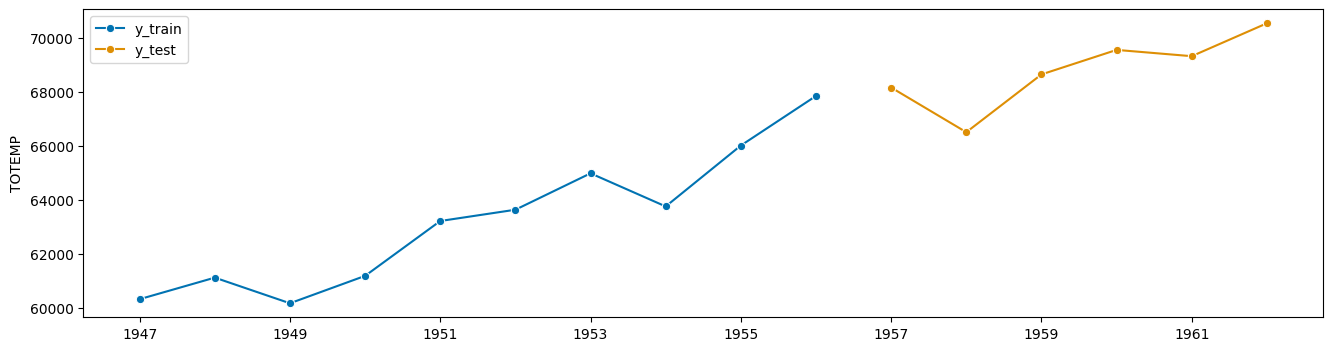

In [102]:
plot_series(y_train, y_test, labels=["y_train", "y_test"]);


In [103]:
X.head()


,GNPDEFL,GNP,UNEMP,ARMED,POP
Period,,,,,
1947,83.0,234289.0,2356.0,1590.0,107608.0
1948,88.5,259426.0,2325.0,1456.0,108632.0
1949,88.2,258054.0,3682.0,1616.0,109773.0
1950,89.5,284599.0,3351.0,1650.0,110929.0
1951,96.2,328975.0,2099.0,3099.0,112075.0


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='TOTEMP'>)

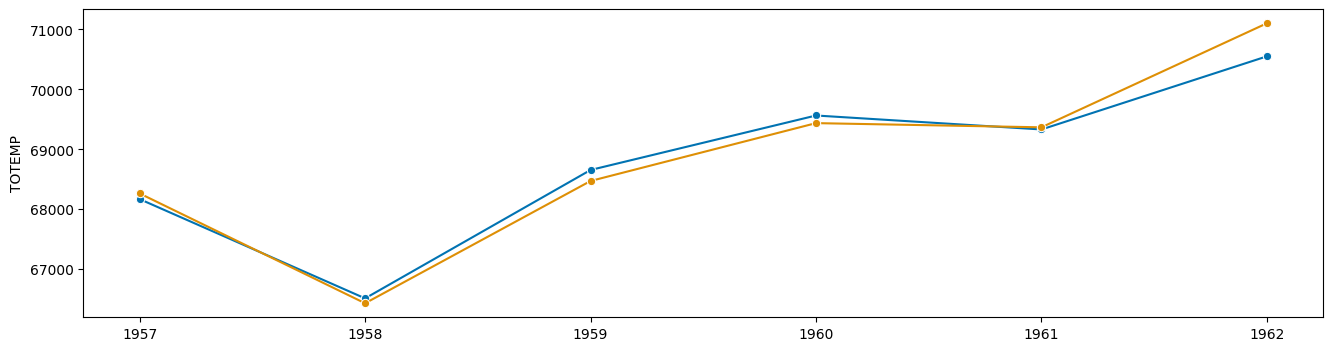

In [104]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import ForecastX
from sktime.forecasting.var import VAR

forecaster_X = ForecastX(
    forecaster_y=AutoARIMA(sp=1, suppress_warnings=True),
    forecaster_X=VAR(),
)
forecaster_X.fit(y=y, X=X, fh=fh)
# now in predict() we don't need to pass X
y_pred = forecaster_X.predict(fh=fh)

plot_series(y_test, y_pred)

## 1.4 Tuning
* Lot of hyperparameters in a pipeline. We want to optimise them:

### 1.4.1 Temporal Cross Validation

In `sktime` there are three different types of temporal cross-validation splitters avilable:
- `SingleWindowSplitter`, which is equivalent to a single train-test-split
- `SlidingWindowSplitter`, which is using a rolling window approach and "forgets" the oldest observations as we move more into the future
- `ExpandingWindowSplitter`, which is using a expanding window approach and keep all observations in the training set as we move more into the future


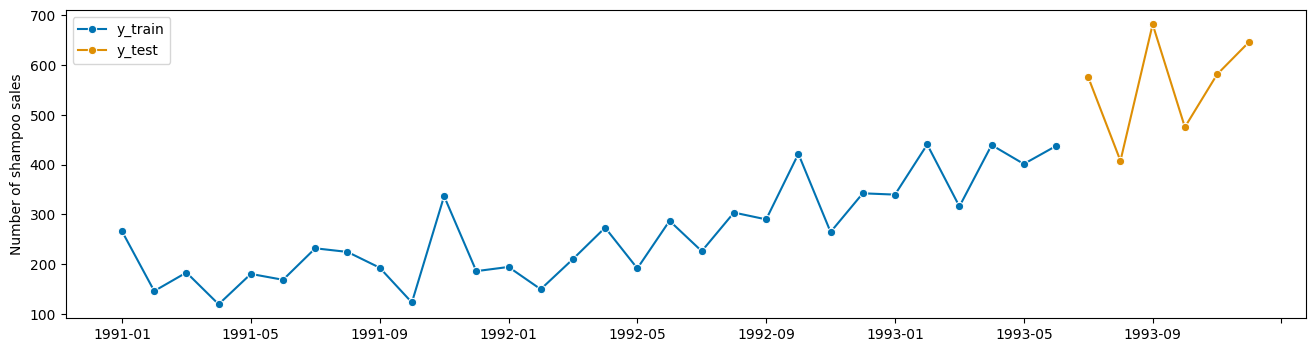

In [105]:
from sktime.datasets import load_shampoo_sales

y = load_shampoo_sales()
y_train, y_test = temporal_train_test_split(y=y, test_size=6)
plot_series(y_train, y_test, labels=["y_train", "y_test"]);

In [106]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    SlidingWindowSplitter,
    SingleWindowSplitter,
)
from sktime.utils.plotting import plot_windows

fh = ForecastingHorizon(y_test.index, is_relative=False).to_relative(
    cutoff=y_train.index[-1]
)

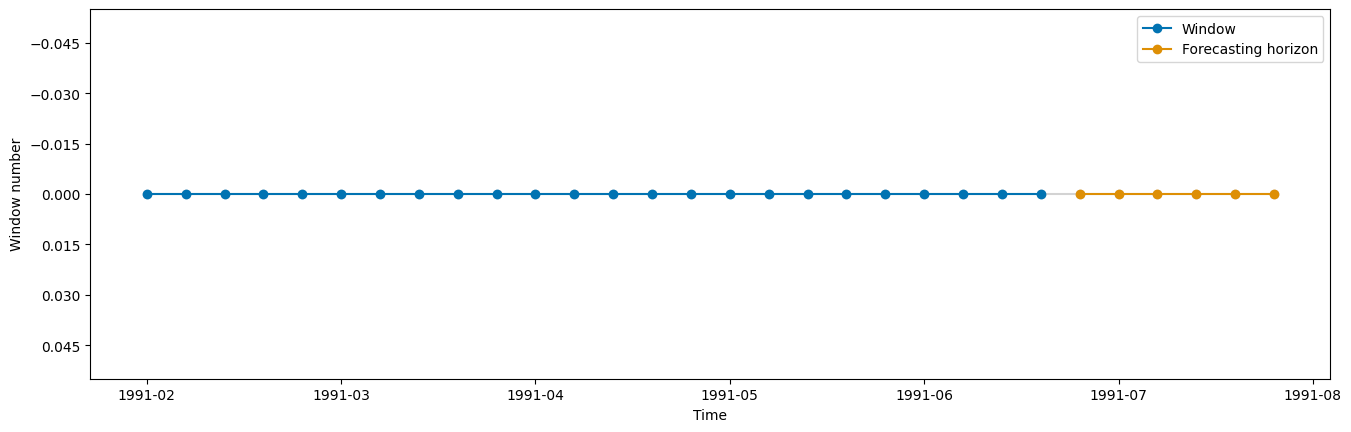

In [107]:
cv = SingleWindowSplitter(fh=fh, window_length=len(y_train) - 6)
plot_windows(cv=cv, y=y_train)

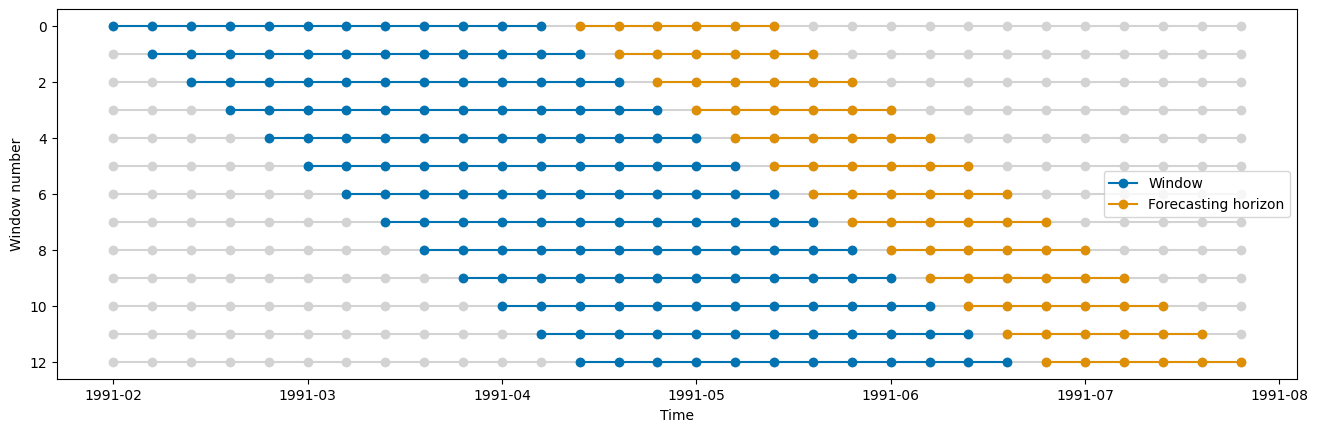

In [108]:
cv = SlidingWindowSplitter(fh=fh, window_length=12, step_length=1)
plot_windows(cv=cv, y=y_train)

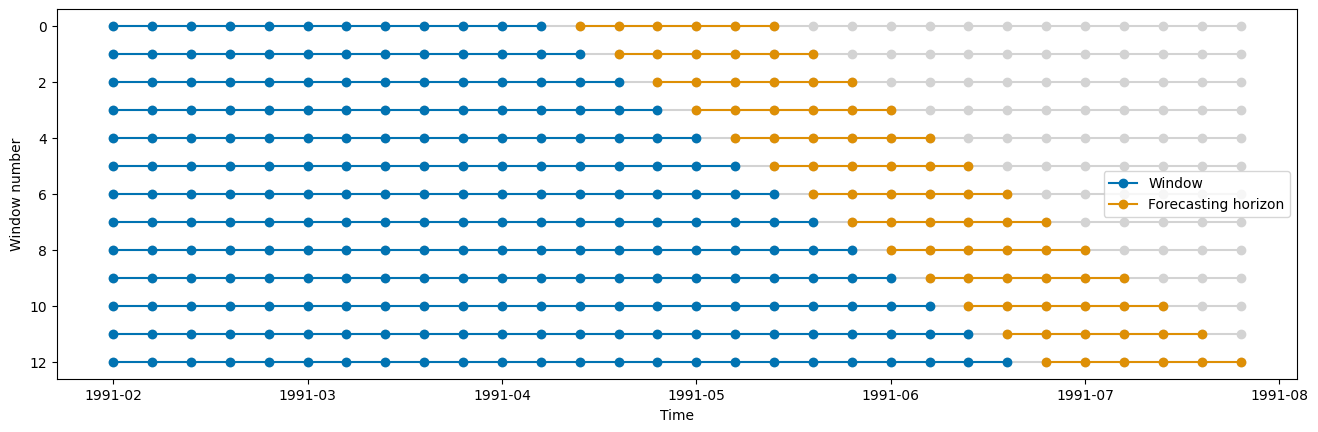

In [109]:
cv = ExpandingWindowSplitter(fh=fh, initial_window=12, step_length=1)
plot_windows(cv=cv, y=y_train)

In [110]:
# get number of total splits (folds)
cv.get_n_splits(y=y_train)

13

### 1.4.2 Grid Search

For tuning parameters with compositions such as pipelines, we can use the \<estimator\>__\<parameter\> syntax known from [scikit-learn](https://scikit-learn.org/stable/modules/grid_search.html#composite-estimators-and-parameter-spaces). For multiple levels of nesting, we can use the same syntax with two underscores, e.g. `forecaster__transformer__parameter`.



In [111]:
from sklearn.preprocessing import PowerTransformer, RobustScaler, MinMaxScaler
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.detrend import Deseasonalizer, Detrender

forecaster = TransformedTargetForecaster(
    steps=[
        ("detrender", Detrender()),
        ("deseasonalizer", Deseasonalizer()),
        ("minmax", TabularToSeriesAdaptor(MinMaxScaler((1, 10)))),
        ("power", TabularToSeriesAdaptor(PowerTransformer())),
        ("scaler", TabularToSeriesAdaptor(RobustScaler())),
        ("forecaster", ExponentialSmoothing()),
    ]
)

# using dunder notation to access inner objects/params as in sklearn
param_grid = {
    # deseasonalizer
    "deseasonalizer__model": ["multiplicative", "additive"],
    # power
    "power__transformer__method": ["yeo-johnson", "box-cox"],
    "power__transformer__standardize": [True, False],
    # forecaster
    "forecaster__sp": [4, 6, 12],
    "forecaster__seasonal": ["add", "mul"],
    "forecaster__trend": ["add", "mul"],
    "forecaster__damped_trend": [True, False],
}

gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    scoring=MeanSquaredError(square_root=True),  # set custom scoring function
)
gscv.fit(y_train)
y_pred = gscv.predict(fh=fh)

NameError: name 'ExponentialSmoothing' is not defined

In [ ]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);


In [ ]:
gscv.best_params_


In [ ]:
gscv.best_forecaster_


In [ ]:
gscv.cv_results_.head()

## 1.5 Summary<a class="anchor" id="chapter5"></a>

* transformers are data processing steps with unified interface - `fit`, `transform`, and optional `inverse_transform`

* used as pipeline components for any learning task, forecasting, classification

* different types by input/output - time series, primitives, pairs of time series, panels/hierarchical.

* find transformers by tags such as `scitype:transform-output` and `scitype:instancewise` using `all_estimators`

* rich composition syntax - `*` for pipe, `+` for featureunion, `[in, out]` for variable subset, `|` for multiplex/switch

* `sktime` provides easy-to-use extension templates for transformers, build your own, plug and play

## 1.6 Appendix - cheat sheets and extension guie

### dunders glossary

| Type | Dunder | Meaning | `sktime` class |
| --- | --- | --- | --- |
| compose | `*` | chaining/pipeline - also works with other estimator types | type dependent |
| compose | `**` | chaining to secondary input of another estimator | type dependent |
| compose | `+` | feature union | `FeatureUnion` |
| interface | `~` | invert | `InvertTransform` |
| structural | `¦` | multiplexing ("switch") | type dependent |
| structural | `-` | optional passthrough ("on/off") | `OptionalPassthrough` |

### selected useful transformers, compositors, adapters

* delay fitting to `transform` via `sktime.transformations.compose.FitInTransform`
* any `pandas` method via `sktime.transformations.compose.adapt.PandasTransformAdaptor`
* date/time features via `sktime.transformations.series.date.DateTimeFeatures`
* lags via `transformations.series.lag.Lag`
* differences, first and n-th, via `transformations.series.difference.Differencer`
* scaled logit via `transformations.series.scaledlogit.ScaledLogitTransform`

### Extension guide - implementing your own transformer<a class="anchor" id="chapter4"></a>

`sktime` is meant to be easily extensible, for direct contribution to `sktime` as well as for local/private extension with custom methods.

To extend `sktime` with a new local or contributed transformer, a good workflow to follow is:

1. read through the [transformer extension template](https://github.com/alan-turing-institute/sktime/blob/main/extension_templates/transformer.py) - this is a `python` file with `todo` blocks that mark the places in which changes need to be added.
2. optionally, if you are planning any major surgeries to the interface: look at the [base class architecture](https://github.com/alan-turing-institute/sktime/blob/main/sktime/transformations/base.py) - note that "ordinary" extension (e.g., new algorithm) should be easily doable without this.
3. copy the transformer extension template to a local folder in your own repository (local/private extension), or to a suitable location in your clone of the `sktime` or affiliated repository (if contributed extension), inside `sktime.transformations`; rename the file and update the file docstring appropriately.
4. address the "todo" parts. Usually, this means: changing the name of the class, setting the tag values, specifying hyper-parameters, filling in `__init__`, `_fit`, `_transform`, and optional methods such as `_inverse_transform` or `_update` (for details see the extension template). You can add private methods as long as they do not override the default public interface. For more details, see the extension template.
5. to test your estimator manually: import your estimator and run it in the worfklows in Section 2.2; then use it in the compositors in Section 2.3.
6. to test your estimator automatically: call `sktime.tests.test_all_estimators.check_estimator` on your estimator. You can call this on a class or object instance. Ensure you have specified test parameters in the `get_test_params` method, according to the extension template.

In case of direct contribution to `sktime` or one of its affiliated packages, additionally:
* add yourself as an author to the code, and to the `CODEOWNERS` for the new estimator file(s).
* create a pull request that contains only the new estimators (and their inheritance tree, if it's not just one class), as well as the automated tests as described above.
* in the pull request, describe the estimator and optimally provide a publication or other technical reference for the strategy it implements.
* before making the pull request, ensure that you have all necessary permissions to contribute the code to a permissive license (BSD-3) open source project.

---

### Credits: notebook 2 - transformers

notebook creation: fkiraly

transformer pipelines & compositors: fkiraly, mloning, miraep8\
forecaster pipelines: fkiraly, aiwalter\
classifier/regressor pipelines: fkiraly\
transformer base interface: mloning, fkiraly\
dunder interface: fkiraly, miraep8

Based on design ideas: sklearn, magrittr, mlr, mlj